Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [2]:
from example_systems.double_pendulum.dp_system import DoublePendulumSystem

In [3]:
import tensorflow_dynamics as tfd

In [ ]:
import gc
import itertools
import math
import numpy as np
import random
import tensorflow as tf
import time

In [5]:
from IPython.display import display, Markdown
from matplotlib import pyplot as plt

# Define the Experiment Loop

In [ ]:
system = DoublePendulumSystem()

In [7]:
t_0 = tf.zeros([1,], dtype=tf.float64)
t_f = tf.ones([1,], dtype=tf.float64) * 2.
time_range = tf.linspace(t_0, t_f, 65)
tfd_time_range = tf.transpose(time_range, [1, 0])

In [36]:
def generate_training_data(traj_count, solver, solver_args):
    if solver_args is None:
        solver_args = dict(rtol=1e-3, atol=1e-3)
    # generate the training data with a true dynamics simulation
    batch_x_0 = tf.random.uniform([traj_count, 4], [-20, -20, -5, -5], [20, 20, 5, 5], dtype=tf.float64)
    p = tf.tile(tf.constant([9.81, 1.0, 1.0, 1.0, 1.0], dtype=tf.float64)[None, :], (traj_count, 1))
    ode_model = lambda t, x: system(x, None, p, t)
    batch_x, tt_rk4 = tfd.de.odeint(ode_model, batch_x_0, tfd_time_range, method=solver, **solver_args)
    return batch_x, tt_rk4

In [ ]:
def experiment(dxdt, terminal_loss, continuous_loss, eval_loss, encoder, decoder,
               epochs=300, lr=1e-3, traj_count=1000, eval_traj_count=200, solver="dopri5", solver_args=None,
               batch_size=1000, adjoint=True, plot_rate=30):
    solver_args = solver_args or dict(rtol=1e-3, atol=1e-3)
    encoder = encoder or tf.identity
    decoder = decoder or tf.identity
        
    # generate the training data to train on and plot the flow field
    batch_x, tt_rk4 = generate_training_data(traj_count+eval_traj_count, solver, solver_args)
    eval_batch_x = batch_x[-eval_traj_count:, ...]
    eval_tt_rk4 = tt_rk4[-eval_traj_count:, ...]
    batch_x = batch_x[:eval_traj_count, ...]
    tt_rk4 = tt_rk4[:eval_traj_count, ...]
    
    # build tensorflow training set and model
    dataset = tf.data.Dataset.from_tensor_slices(batch_x)
    dataset = dataset.shuffle(traj_count, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    learning_ode_func = lambda t, x: dxdt(x)
    learning_solver = tfd.de.OdeintSolver(learning_ode_func,
                                          continuous_loss_func=continuous_loss,
                                          method=solver,
                                          options=solver_args,
                                          adjoint_options=solver_args)
    
    # touch the learning model
    learning_solver.odeint(encoder(batch_x[:batch_size, 0, :]), tfd_time_range)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = []
    start_time_s = time.time()
    for epoch in range(epochs):
        epoch_avg_loss = []
        for batch in dataset:
            with tf.GradientTape() as tape:
                batch_in = encoder(batch[..., 0, :])
                if adjoint:
                    xt_hat, *_ = learning_solver.odeint_adjoint(batch_in, tfd_time_range)
                else:
                    xt_hat, *_ = learning_solver.odeint(batch_in, tfd_time_range)
                xt_hat = decoder(xt_hat)
                err = terminal_loss(xt_hat, batch)
            grads = tape.gradient(err, dxdt.trainable_variables)
            optimizer.apply_gradients(zip(grads, dxdt.trainable_variables))
            epoch_avg_loss.append(err)
        epoch_avg_loss = np.mean(epoch_avg_loss)
        losses.append(epoch_avg_loss)
        print(f"{epoch}: {epoch_avg_loss}")

        # plot the flow field at the end of the epoch
        if plot_rate > 0 and epoch % plot_rate == 0:
            plot_learned_flow_field(dxdt, big_coords)
    duration_s = time.time() - start_time_s
    print(f"Training finished. Took {duration_s:.3f} seconds.")
        
    # plot the training curve
    plt.plot(losses)
    plt.title("Losses")
    plt.xlabel("Epochs")
    
    # run a quick evaluation
    eval_avg_loss = []
    batch_in = encoder(eval_batch_x[..., 0, :])
    xt_hat, *_ = learning_solver.odeint(batch_in, tfd_time_range)
    xt_hat = decoder(xt_hat)
    err = eval_loss(xt_hat, eval_batch_x)
    eval_avg_loss = tf.reduce_mean(err)
    print(f"Eval loss: {eval_avg_loss:.2f}")
    
    return duration_s, eval_avg_loss

# Experiments

## Experiment Library

In [10]:
def terminal_only_loss(y_hat, y):
    return tf.reduce_mean(
        tf.linalg.norm(y_hat[..., -1, :] - y[..., -1, :], axis=-1)
    )

In [11]:
def all_states_loss(y_hat, y):
    return tf.reduce_mean(tf.linalg.norm(y_hat - y))

In [12]:
def create_optimal_transport_loss(dxdt, lambda_1):
    def optimal_transport_loss(t, y):
        return lambda_1 * tf.linalg.norm(dxdt(y), axis=-1, keepdims=True)
    return optimal_transport_loss

In [13]:
def create_jac_norm_loss(dxdt, sample):
    def jac_norm_loss(t, y):
        with tf.GradientTape() as tape:
            dy = dxdt(t, y)[..., None]
        jac = tape.batch_jacobian(dy, y)
        return tf.norm(jac, 'fro')
    return jac_norm_loss

In [14]:
def feed_forward_model(activation='tanh', initializer=None, layers=None, out_dim=4):
    layers = layers or [16, 16]
    dense_layers = [tf.keras.layers.Dense(l, activation=activation, dtype=tf.float64,
                                          kernel_initializer=initializer) for l in layers]
    dense_layers += [tf.keras.layers.Dense(out_dim, dtype=tf.float64, kernel_initializer=initializer),]
    dxdt = tf.keras.Sequential(dense_layers)
    return dxdt

In [15]:
class RotationalEncoding1d(tf.keras.Model):
    def __init__(self, activation='tanh', initializer=None, layers=None):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(activation, initializer, layers)
        
    def call(self, x):
        theta_1, theta_2, omega_1, omega_2 = tf.unstack(x, axis=-1)
        theta_1_enc = tf.math.floormod(theta_1 + 10*math.pi, 2*math.pi)
        theta_2_enc = tf.math.floormod(theta_2 + 10*math.pi, 2*math.pi)
        x_enc = tf.stack([theta_1_enc, theta_2_enc, omega_1, omega_2], axis=-1)
        return self._dxdt(x_enc)

In [16]:
class RotationalEncoding2d(tf.keras.Model):
    def __init__(self, activation='tanh', initializer=None, layers=None):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(activation, initializer, layers)
        
    def call(self, x):
        theta_1, theta_2, omega_1, omega_2 = tf.unstack(x, axis=-1)
        x_enc = tf.stack([tf.math.sin(theta_1), tf.math.cos(theta_1),
                          tf.math.sin(theta_2), tf.math.cos(theta_2),
                          omega_1, omega_2], axis=-1)
        return self._dxdt(x_enc)

In [17]:
class RotationalEncoding1dOrder2(tf.keras.Model):
    def __init__(self, activation='tanh', initializer=None, layers=None):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(activation, initializer, layers, out_dim=2)
        
    def call(self, x):
        theta_1, theta_2, omega_1, omega_2 = tf.unstack(x, axis=-1)
        theta_1_enc = tf.math.floormod(theta_1 + 10*math.pi, 2*math.pi)
        theta_2_enc = tf.math.floormod(theta_2 + 10*math.pi, 2*math.pi)
        x_enc = tf.stack([theta_1_enc, theta_2_enc, omega_1, omega_2], axis=-1)
        angular_acc = self._dxdt(x_enc)
        return tf.concat([x[..., 2:], angular_acc], axis=-1)

In [18]:
class RotationalEncoding2dOrder2(tf.keras.Model):
    def __init__(self, activation='tanh', initializer=None, layers=None):
        super().__init__(autocast=False)
        self._dxdt = feed_forward_model(activation, initializer, layers, out_dim=2)
        
    def call(self, x):
        theta_1, theta_2, omega_1, omega_2 = tf.unstack(x, axis=-1)
        x_enc = tf.stack([tf.math.sin(theta_1), tf.math.cos(theta_1),
                          tf.math.sin(theta_2), tf.math.cos(theta_2),
                          omega_1, omega_2], axis=-1)
        angular_acc = self._dxdt(x_enc)
        return tf.concat([x[..., 2:], angular_acc], axis=-1)

In [19]:
def create_model(name, activation='tanh', initializer=None, layers=None):
    if name == "node":
        return feed_forward_model(activation, initializer, layers)
    if name == "rotational_encoding_1d":
        return RotationalEncoding1d(activation, initializer, layers)
    if name == "rotational_encoding_2d":
        return RotationalEncoding2d(activation, initializer, layers)
    if name == "rotational_encoding_1d_order_2":
        return RotationalEncoding1dOrder2(activation, initializer, layers)
    if name == "rotational_encoding_2d_order_2":
        return RotationalEncoding2dOrder2(activation, initializer, layers)

In [20]:
xavier = tf.keras.initializers.GlorotUniform(seed=0)
xavier_norm = tf.keras.initializers.GlorotNormal(seed=0)
init_random = tf.keras.initializers.RandomUniform(seed=0)
init_random_norm = tf.keras.initializers.RandomNormal(seed=0)
init_constant_0_5 = tf.keras.initializers.Constant(value=0.5)
init_constant_1 = tf.keras.initializers.Constant(value=1.)

In [39]:
epochs = 200
solver = "rk4"
solver_args=dict(h=tf.cast(1./16., tf.float64))
adjoint=False
traj_count = 1000
eval_traj_count = 200

In [22]:
batch_sizes = [32, 64, 128]
activations = ("tanh", "relu")
initializers = {#"xavier": xavier,
                "xavier_norm": xavier_norm,
                #"init_random": init_random,
                #"init_random_norm": init_random_norm
}
losses = {#"terminal_only": terminal_only_loss,
          "all_states": all_states_loss
}
models = ["node",
          #"rotational_encoding_1d",
          "rotational_encoding_2d",
          #"rotational_encoding_1d_order_2",
          "rotational_encoding_2d_order_2"]
adjoints = [True, False]

# Big Grid Search


(32, 'tanh', 'xavier_norm', 'all_states', 'node', True)

0: 386.6198685710018
1: 379.85449088256206
2: 379.31017428341545
3: 378.51751693975154
4: 375.41762889425667
5: 375.373007166032
6: 373.88891070331937
7: 375.4252323283178
8: 370.03808763930965
9: 373.29856158340147
10: 369.0082742418437
11: 370.86269373883357
12: 375.8316030850548
13: 366.1261874963831
14: 365.4013140218337
15: 368.24741434986
16: 368.60094067930487
17: 368.1303848712282
18: 362.3366913328423
19: 365.56666454871004
20: 363.50772332812903
21: 360.3598430741379
22: 363.1923400182831
23: 359.7554936032501
24: 361.9330393491179
25: 359.73194743082917
26: 360.4402016965444
27: 354.2078597713292
28: 358.4038344838669
29: 354.4665889945275
30: 356.48324237703974
31: 353.25485194091914
32: 357.311753640428
33: 353.12064592648954
34: 350.875832709501
35: 352.3185754088914
36: 352.3086737111668
37: 355.5219495744737
38: 349.01158144213395
39: 351.0321905389532
40: 347.4931079401822
41: 351.2174527833749
42: 350.812566144

153: 327.144169714767
154: 325.3113668561697
155: 328.19854416207005
156: 330.02661006761997
157: 328.07054537310836
158: 329.11192774842914
159: 326.9203932443416
160: 324.8039354621763
161: 324.0404285637418
162: 326.97321999531266
163: 324.6060999061064
164: 328.49707968697334
165: 326.1136122679358
166: 325.0217840930559
167: 323.260253963724
168: 324.87645171579544
169: 322.91912749647463
170: 324.1888651842808
171: 327.1071607381995
172: 324.08825938421376
173: 324.127297013451
174: 324.5328335754784
175: 323.551247571451
176: 329.52247829523594
177: 323.8332550898821
178: 322.2946546432026
179: 325.975374558006
180: 328.89955997129033
181: 324.7188452934193
182: 328.5087963497318
183: 324.02550135395916
184: 321.8749093770999
185: 322.2137782479889
186: 322.5561614222885
187: 320.022122868624
188: 320.3770493792341
189: 323.17422589884444
190: 323.3445364686011
191: 328.4821818733165
192: 321.013763376763
193: 327.4588918784978
194: 322.4464169861474
195: 325.9945825388345
196: 

102: 293.9026735935903
103: 293.9944377003475
104: 296.64860622432343
105: 297.20608381217636
106: 296.07491182137477
107: 292.49172416298194
108: 296.35097789970314
109: 294.22712465212453
110: 293.65697542470076
111: 292.35819780592476
112: 296.6618723132765
113: 294.1366395436488
114: 293.7178013053963
115: 295.019175187616
116: 296.2185872827533
117: 296.88729314369175
118: 294.30573149339256
119: 293.1079229002061
120: 290.66261411362024
121: 290.5737950347812
122: 293.8711041106773
123: 290.04725412761695
124: 289.0563542492656
125: 291.7581416632965
126: 292.72598557673075
127: 290.4439049617154
128: 291.39175006075476
129: 296.73767178032193
130: 293.3815548481756
131: 291.4196633277994
132: 290.175004080275
133: 289.5989975038155
134: 290.8111827074866
135: 289.87274915512796
136: 290.7314571880566
137: 291.255265105317
138: 293.80321236957616
139: 291.06760482622593
140: 287.57215682072325
141: 287.8923319828932
142: 289.2500669784148
143: 289.7035268561074
144: 284.846441573

48: 319.50803607706996
49: 323.36915258790896
50: 320.6510193449573
51: 322.1023766353064
52: 320.855075654958
53: 319.98825182387867
54: 317.1057264446852
55: 315.23076365891455
56: 317.49312648630587
57: 318.3377525738411
58: 311.84139948845393
59: 313.0400781768274
60: 312.61788551937997
61: 312.80682101004214
62: 316.48378366209454
63: 310.08242324656203
64: 308.2775283103405
65: 307.4575580999494
66: 309.39134606142574
67: 303.5356144898853
68: 312.94109799539
69: 309.3769223744858
70: 306.34321328246057
71: 310.1863190707363
72: 304.97609258407454
73: 305.60388737018235
74: 302.9035369884783
75: 303.7966214516612
76: 302.9552740415983
77: 305.5384053932161
78: 299.1931817565797
79: 300.02874392807547
80: 305.20736472532377
81: 298.3112052046883
82: 298.62217541311287
83: 300.613115873335
84: 297.08103453434666
85: 298.48479015671467
86: 297.9023661801918
87: 299.96740201251214
88: 295.7092217928356
89: 295.32983662334726
90: 303.34881426667033
91: 300.4627220770926
92: 295.388582

Eval loss: 10.18

(32, 'relu', 'xavier_norm', 'all_states', 'node', False)

0: 402.15752514672823
1: 390.1945056191372
2: 384.72295710527715
3: 380.5117122924289
4: 376.1159021776295
5: 374.22880920771485
6: 371.4088975694851
7: 372.93391983174536
8: 367.2731964040471
9: 370.4567759036155
10: 365.7571539269541
11: 367.3417092949789
12: 371.9943588979254
13: 362.6910773268647
14: 362.5091948352729
15: 365.6647375343801
16: 364.98193586991107
17: 365.549322029935
18: 359.5442369114568
19: 362.87192195781466
20: 361.0391973495278
21: 357.67176191964666
22: 360.68870893534125
23: 356.6214695521161
24: 359.1697074388465
25: 357.1552299331364
26: 357.8943500715763
27: 351.9158841496236
28: 355.5812922668556
29: 352.16515796430184
30: 353.9214908797149
31: 350.9542684108753
32: 354.18568935300425
33: 349.7188308277505
34: 348.6074477498963
35: 349.5148901087191
36: 348.3737655773566
37: 352.5748232135616
38: 345.6361489336727
39: 347.44750895786666
40: 344.019739948105
41: 346.4698779606302
4

152: 308.3890215678151
153: 310.14858300295697
154: 308.1578773000174
155: 313.59676035071664
156: 314.6641275377773
157: 311.73731534996824
158: 313.7889491577528
159: 311.8538827480266
160: 310.2137651440208
161: 309.9337741371446
162: 311.89339062885784
163: 308.807618559603
164: 313.0919071597784
165: 310.3359069824722
166: 310.2980433603893
167: 308.0128780676271
168: 310.5999709323324
169: 307.17440805535637
170: 306.59333296277595
171: 311.7500951803064
172: 309.8618525268734
173: 309.16085790697224
174: 309.4173248126593
175: 307.73230829911074
176: 313.4036406705007
177: 308.70936168312267
178: 305.9369001710555
179: 309.88657480723623
180: 314.5467342382276
181: 311.3024986913732
182: 313.05867926180235
183: 308.4137396553747
184: 306.97189614457375
185: 306.9900894349242
186: 307.14308513524276
187: 304.8321780732544
188: 304.65949167668987
189: 309.0555647817725
190: 308.94274861516254
191: 313.6515437934485
192: 306.2622255151096
193: 312.4437183075007
194: 308.33291685354

100: 307.64939916232686
101: 306.3782600948994
102: 302.6226626531581
103: 303.2912211557053
104: 306.2045793125076
105: 305.7749200440867
106: 303.507011198354
107: 300.8356674905852
108: 303.1589973573378
109: 303.14519730114984
110: 301.56914739198555
111: 299.8314190583407
112: 302.8149157663029
113: 302.3720075109646
114: 300.96309722217677
115: 302.34557157918186
116: 303.4179904575438
117: 303.727773211849
118: 301.3883489455612
119: 300.2145506051992
120: 296.6196709200417
121: 297.205733535982
122: 300.02833004517095
123: 296.6255564559898
124: 296.0910445784448
125: 299.2303741602627
126: 298.40843534974346
127: 298.29485130519197
128: 297.65206512059154
129: 303.67415914906513
130: 300.0047723868491
131: 297.5632776107994
132: 295.9108138916021
133: 297.2609241202666
134: 295.6832089192343
135: 296.10171547822364
136: 297.16290385619334
137: 298.00922118365753
138: 299.47704523351376
139: 298.01265855404546
140: 294.7839644641795
141: 294.68973379228606
142: 296.673710316732

47: 465.96001061100895
48: 448.1124918674732
49: 453.58734319521574
50: 451.0735880963578
51: 455.8784167687071
52: 454.7248983590699
53: 451.49013782471604
54: 448.3547401967844
55: 445.25259905872207
56: 450.9608108653949
57: 454.14199071110727
58: 444.33564531356086
59: 443.58428535985445
60: 444.05947046918743
61: 449.634630160948
62: 456.2343993291463
63: 443.6519731685666
64: 442.84356076211884
65: 440.6659915318653
66: 444.5011415981463
67: 436.89468446992544
68: 457.34044297961384
69: 448.82427693335865
70: 445.80830871088517
71: 452.0487718480616
72: 445.01175822561004
73: 441.75121441757574
74: 441.8049921452895
75: 446.4344678179845
76: 443.5250206500109
77: 450.63030411522493
78: 433.987845202817
79: 439.8551515111908
80: 451.394677346859
81: 436.9557430489016
82: 438.0932991126173
83: 443.10664072220357
84: 432.8298799455304
85: 436.72199169307487
86: 438.13945455248967
87: 445.442382653661
88: 434.01911488432495
89: 435.7947049933522
90: 452.2775385837572
91: 445.63580328

Eval loss: 9.71

(64, 'tanh', 'xavier_norm', 'all_states', 'rotational_encoding_2d', True)

0: 483.5848219055646
1: 468.61318695414786
2: 465.55526333204676
3: 463.7273668309901
4: 459.6319525517833
5: 460.2535344618101
6: 454.38598416657476
7: 459.8584481866054
8: 448.2340877856094
9: 456.3837148654527
10: 448.794227893643
11: 453.58669954149985
12: 465.5126703905995
13: 442.85859087224696
14: 442.7494614586178
15: 451.31258151530744
16: 451.91833369946403
17: 450.3140781359559
18: 440.0945324251989
19: 447.46446218118086
20: 444.6537121391414
21: 438.3786261732678
22: 445.8171154185025
23: 438.1364198915417
24: 446.0174750749703
25: 439.1125399137255
26: 440.4873330447841
27: 431.3592326321761
28: 440.00866737762067
29: 430.7259503836407
30: 434.76264835323815
31: 430.20660474281675
32: 437.22337562003094
33: 429.40666251350905
34: 427.21795890720585
35: 430.09480136264017
36: 429.5337348761796
37: 437.3344741383364
38: 424.6915481032872
39: 427.9075053495652
40: 421.14827253627584
4

151: 375.8848178071254
152: 371.14962628223464
153: 376.13472586621435
154: 372.3192630248859
155: 385.130595688389
156: 383.6310968218423
157: 376.2245131671855
158: 380.33564863156755
159: 376.8731483356855
160: 375.14873035830806
161: 373.07277738314366
162: 376.3246418509464
163: 374.82271033207445
164: 380.1891249389884
165: 375.99756710977624
166: 372.2302645048217
167: 371.5503212515378
168: 373.439055917043
169: 370.87089227123806
170: 372.5179786432878
171: 379.4736128927098
172: 374.3941221926725
173: 374.1414779823685
174: 377.5528519321632
175: 370.43903783088473
176: 385.29495103670274
177: 369.59825448776155
178: 368.2061204973025
179: 378.10462918709317
180: 383.7116746016486
181: 375.54292707852255
182: 382.73429754274866
183: 369.9694106367649
184: 375.9829966722432
185: 371.1171895942958
186: 373.77597598987984
187: 364.51124980362925
188: 364.05675033938155
189: 370.84309742783546
190: 373.86523820336345
191: 385.3686448727046
192: 369.1365518876952
193: 385.28109367

100: 403.3556367468588
101: 400.2830911124905
102: 395.3381036058588
103: 395.74072745283695
104: 402.1139474995431
105: 402.09668443073843
106: 394.5518763359381
107: 389.3535465994011
108: 395.1772491462411
109: 399.16679884545306
110: 391.7914778638653
111: 389.54015741571175
112: 398.5618907131446
113: 395.2373504495742
114: 392.7534820127278
115: 394.8442403891643
116: 398.13565851771
117: 399.321017555068
118: 390.34303254633033
119: 390.51643935833545
120: 383.9400860256365
121: 385.24013253478336
122: 389.5700267426325
123: 383.6705816888031
124: 382.11103633218073
125: 384.4278973810183
126: 386.9880954253946
127: 386.35992347528895
128: 383.6727559412976
129: 398.32582392423217
130: 393.45887546802436
131: 383.3210786256698
132: 384.24305222832663
133: 384.6166796316829
134: 383.0479146027071
135: 383.5337758014046
136: 382.40485921743834
137: 388.58530259686313
138: 389.1295064127902
139: 387.0813703475076
140: 379.94236076403433
141: 380.17733763649113
142: 380.786659538236

48: 445.33024117602895
49: 450.8979709562336
50: 448.1943760460614
51: 453.37397894139133
52: 451.3994237587966
53: 448.4218199593421
54: 444.95196764353557
55: 442.11197018552167
56: 447.08186452391624
57: 449.9886821676554
58: 439.4701675231418
59: 440.188929637501
60: 440.3018591078031
61: 444.98612777593564
62: 450.4471375115964
63: 439.57404600811003
64: 439.3256006710618
65: 436.1825719001247
66: 438.94298095423846
67: 431.41347759252255
68: 450.58527503243533
69: 444.47907287680846
70: 440.33249922996316
71: 446.4947268142475
72: 437.60066959641273
73: 435.78696124834767
74: 434.9704070397111
75: 439.4428567668678
76: 436.0622476062164
77: 441.8127541266789
78: 427.5504123077079
79: 432.3637321188327
80: 441.79479737945985
81: 428.70374565944866
82: 430.3149103165844
83: 435.12413405890976
84: 424.5817882046438
85: 427.89439367396085
86: 429.57897808289545
87: 436.525163785556
88: 423.77112569066924
89: 426.36473591604096
90: 440.6413413073291
91: 436.6535982468132
92: 424.57579

Eval loss: 9.08

(64, 'relu', 'xavier_norm', 'all_states', 'rotational_encoding_2d', False)

0: 496.9984766462969
1: 482.6146000036342
2: 478.7546185381857
3: 477.71929298902865
4: 473.4967143817836
5: 473.25570595756386
6: 467.3252060407981
7: 473.4215261802746
8: 461.4565324389322
9: 469.1014856710409
10: 461.11961826040795
11: 465.02244774213517
12: 476.6694614750895
13: 454.07329208199945
14: 452.4575649988639
15: 461.7129427937527
16: 461.1815144665076
17: 458.83914911532406
18: 448.6736410673405
19: 454.81279442058644
20: 452.1734979797134
21: 444.7046910096515
22: 452.1970162544584
23: 444.34709738733875
24: 451.856392615173
25: 445.74406383357433
26: 446.9142370816308
27: 436.40841188420035
28: 445.6878535934384
29: 435.43818882001295
30: 439.3674256970435
31: 434.5661480820294
32: 442.82102934020054
33: 433.60018625635615
34: 430.60321663897366
35: 434.8844758367354
36: 433.1035585161078
37: 440.5842026283277
38: 428.20637923469576
39: 430.8556758467272
40: 423.34880494322067


151: 391.89440048652745
152: 385.80554076242845
153: 392.24667234389
154: 385.6237216620283
155: 395.8659385242763
156: 397.1785748606864
157: 390.34873299881053
158: 395.1118092825784
159: 388.8350232401543
160: 387.38414552779614
161: 386.5796318416765
162: 388.3762857921311
163: 385.59676258098324
164: 392.51686267510985
165: 386.7585157495227
166: 384.1331280691408
167: 382.6298284299267
168: 385.8111861952653
169: 381.3687546261013
170: 384.64502231269483
171: 390.66142861333674
172: 384.78517909888654
173: 385.9269696924241
174: 385.5133772960519
175: 379.7178045869731
176: 394.70944594274357
177: 382.87397209285376
178: 376.89386671913815
179: 387.1290219521181
180: 394.89648488182036
181: 386.00895445712075
182: 391.1794727715191
183: 378.1288872930657
184: 384.56285242342835
185: 382.2436053447587
186: 384.4795400720318
187: 373.89848428222456
188: 374.45806701052436
189: 379.42012482584005
190: 381.8624559586556
191: 394.45752709139515
192: 378.10998695877777
193: 394.5326278

103: 664.1277300649431
104: 653.5999864591491
105: 659.7965071864526
106: 649.6967333656806
107: 653.7327991351208
108: 658.0331089223854
109: 658.235760905962
110: 653.0929848667251
111: 658.8351145166464
112: 655.1113358582312
113: 656.6114995050877
114: 658.0186944184388
115: 647.9866791094523
116: 657.8106792107717
117: 655.968189526136
118: 658.1382143548478
119: 653.3471836170007
120: 645.7306111488249
121: 653.7730425945214
122: 651.2226282080626
123: 655.3208888738944
124: 651.8941005521372
125: 653.2303321518646
126: 647.6274970863907
127: 652.7211711734471
128: 641.8998697604327
129: 655.9577320452513
130: 647.6695319989512
131: 644.1184137379104
132: 652.267323484911
133: 647.8474911596953
134: 642.5919238741374
135: 645.7805790865532
136: 654.8956893729367
137: 655.8178591357289
138: 651.4892458404604
139: 646.5647178254184
140: 646.4122562239104
141: 653.9009365781693
142: 640.4454201549946
143: 639.9960363708901
144: 650.6125654440989
145: 647.5254121948894
146: 645.79558

58: 635.8483424927879
59: 639.4316868349914
60: 633.5003454933897
61: 639.5121809952407
62: 636.2205696619719
63: 636.4973831149166
64: 634.4278634953369
65: 634.7179516062184
66: 633.6554443106852
67: 623.358191428303
68: 634.522433656006
69: 628.8600826017702
70: 630.8841332271904
71: 632.3870692809814
72: 629.4308154785452
73: 628.488584281313
74: 629.2266697947559
75: 629.9855942465197
76: 626.4222605421162
77: 631.4649814194352
78: 627.6009061721813
79: 625.3466701250857
80: 632.1047074135593
81: 629.4414915502787
82: 624.9386347854022
83: 624.0796900417208
84: 624.7734893988336
85: 615.5048047527938
86: 628.3475014874992
87: 626.8621929427832
88: 624.9667621922966
89: 623.1997015161713
90: 625.99767007589
91: 620.8821483085451
92: 621.5349587933545
93: 622.3659734798001
94: 617.4776405454752
95: 626.7589850755858
96: 618.0190384825878
97: 623.1564437416353
98: 622.9492530463706
99: 624.0805833754569
100: 621.4296001124915
101: 619.7248773093299
102: 626.273974833793
103: 625.4106

12: 767.2081173387103
13: 763.1419067914183
14: 745.4683130256021
15: 754.3048446267912
16: 745.0987345364834
17: 742.1415609550877
18: 728.688451494915
19: 730.2092991844268
20: 727.4256158895503
21: 728.7645262922547
22: 714.1225966546442
23: 727.4868438998903
24: 722.4038721967745
25: 712.6315698066562
26: 709.7271266095538
27: 706.1463518361629
28: 705.0608585823766
29: 704.1312077188056
30: 706.5694594475628
31: 696.572778958596
32: 701.7722317349906
33: 701.5458325047344
34: 695.4623102993613
35: 689.8248467118077
36: 683.2528410728839
37: 691.93114129514
38: 677.4794681110449
39: 679.6732494824099
40: 685.3369950740765
41: 684.1579181248852
42: 684.9298094796206
43: 671.3682123864025
44: 678.7537807606859
45: 678.4370771931322
46: 675.7341582880424
47: 677.573725154147
48: 677.1268356105616
49: 667.3197227718442
50: 675.3258199644265
51: 666.0565871046904
52: 669.83746711208
53: 675.4564400767559
54: 663.8812558796594
55: 667.3582126521892
56: 673.357831664111
57: 661.5330696406

173: 588.6513096675042
174: 601.3702127144875
175: 594.1221733131367
176: 599.6038436438791
177: 595.0149733499698
178: 591.8891602184573
179: 593.7511700122848
180: 597.1009340103062
181: 587.5572785516042
182: 594.6939741839033
183: 592.5141438722925
184: 587.121378010968
185: 591.4856755197478
186: 595.6913924342956
187: 589.6190899101923
188: 592.5783909887148
189: 588.0289142190767
190: 582.7111370660434
191: 588.2845433358041
192: 577.0280323676175
193: 593.1191444329179
194: 590.7320471507643
195: 585.0813669858969
196: 587.434477956409
197: 578.1866516058705
198: 585.6373326347293
199: 585.7173634718122
Training finished. Took 1159.121 seconds.
Eval loss: 8.95

(128, 'relu', 'xavier_norm', 'all_states', 'node', True)

0: 759.7925438136635
1: 747.8129582243666
2: 746.0081233717196
3: 738.8916512816212
4: 732.8392895552244
5: 734.8665543721959
6: 726.6903481998061
7: 722.9373543928889
8: 721.1771172639842
9: 721.5902680315542
10: 716.3357602029391
11: 716.7062265726919
12: 715.25

131: 633.5526438523962
132: 640.4732681141951
133: 635.9034993865939
134: 630.5683208951873
135: 633.145885273062
136: 642.0697966889777
137: 642.446199857332
138: 638.7635250884471
139: 632.9615807774212
140: 634.2549250324973
141: 639.6358136102651
142: 628.1115586743775
143: 626.2580296307916
144: 635.8308900142927
145: 633.4763145603793
146: 631.7747733937388
147: 638.9671832238637
148: 634.1021910641642
149: 636.9300340016971
150: 632.5186285711361
151: 632.4200586867413
152: 632.8434194430438
153: 629.0261899738159
154: 632.3733391933511
155: 628.7927564536137
156: 629.3677304071466
157: 629.263270806231
158: 631.5605075221034
159: 628.8326342302878
160: 630.0042822238961
161: 619.2073324223594
162: 628.3558865178134
163: 629.9587382774421
164: 630.480862727509
165: 626.7012545328388
166: 626.6301346447044
167: 621.4928596012733
168: 624.9556890534393
169: 624.4977045754999
170: 627.2922358336388
171: 626.9248923021385
172: 615.0423077722107
173: 616.5942184211865
174: 628.694901

87: 627.7029131143847
88: 624.869263007487
89: 622.2776406146198
90: 625.9492920063285
91: 620.9392898436038
92: 621.1143567002614
93: 621.5303654285622
94: 615.1525116545616
95: 625.1648607175682
96: 615.4577533691984
97: 620.6916016227563
98: 619.4309588600468
99: 621.0385139878745
100: 617.7311418282297
101: 615.3913816363996
102: 621.7203848032938
103: 620.701880232182
104: 611.3260004122636
105: 615.1662503644793
106: 605.0778326743217
107: 608.7426905033437
108: 613.0558929341823
109: 614.0267134993152
110: 606.6646542953449
111: 612.1203423435173
112: 608.6441581998979
113: 609.1071171999245
114: 610.644554830001
115: 601.1746330245568
116: 610.0252170881273
117: 608.8214881155782
118: 609.1765780501596
119: 603.6044683850592
120: 595.7042976667246
121: 603.8337373676375
122: 602.264233223901
123: 604.0706083876644
124: 600.1668199841669
125: 601.396228504451
126: 595.6515640780333
127: 599.6547377264881
128: 588.9381661181176
129: 602.5009637997608
130: 592.8724956126565
131: 5

40: 683.3718383933411
41: 682.4544168288226
42: 683.0338018706827
43: 669.4596271176772
44: 675.2447893373185
45: 676.0587509251876
46: 672.8732360212111
47: 674.286032541914
48: 672.8834251415262
49: 663.1990438374073
50: 670.8244260334315
51: 661.7131918306138
52: 664.8444754270763
53: 670.1016369529248
54: 658.969729202913
55: 661.5239039797268
56: 666.5379975917599
57: 654.9408855148838
58: 655.4663067746735
59: 659.3277483509964
60: 653.0118992034595
61: 659.5242968414352
62: 655.1633202674193
63: 654.207680149465
64: 652.4818852490303
65: 651.4887426811124
66: 651.1256584744785
67: 638.8081756874052
68: 650.1488071478606
69: 644.2077365436551
70: 645.4870554504989
71: 647.2692786649455
72: 643.6496559951537
73: 640.1718245403384
74: 642.6773351858466
75: 642.669653388257
76: 638.8761594306295
77: 642.3593313374595
78: 638.2290598838409
79: 636.586561686715
80: 642.802437617131
81: 639.2779660535734
82: 633.2318334051187
83: 633.960179833709
84: 632.7947595524148
85: 623.060997116

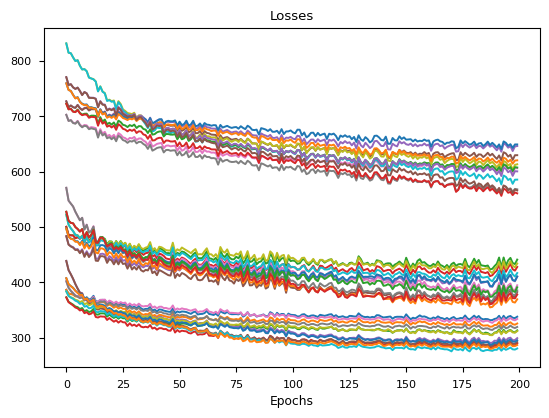

In [40]:
results = {}
for param_set in itertools.product(batch_sizes, activations, initializers.keys(), losses.keys(), models, adjoints):
    print(f"\n{param_set}\n")
    bs, activ, init, loss, model, adjoint = param_set
    tf.random.set_seed(0)
    tf.keras.backend.clear_session()
    gc.collect()
    dxdt = create_model(model, activ, initializers[init])
    duration_s, loss = experiment(dxdt, losses[loss], None, terminal_only_loss, None, None, epochs=epochs, lr=1e-3,
                                  traj_count=traj_count, eval_traj_count=eval_traj_count, solver=solver,
                                  solver_args=solver_args, batch_size=bs, adjoint=adjoint, plot_rate=0)
    results[param_set] = (duration_s, loss)

In [41]:
table = """
| Model | Activation | Initialization | Loss Function | Batch Size | Adjoint | duration (s) | evaluation loss (mse) |
| ----- | ---------- | -------------- | ------------- | ---------- | ------- | ------------ | --------------------- |
"""

best_set = min(results.items(), key=lambda i: i[1][1])[0]

for params, (duration_s, eval_loss) in results.items():
    bs, activ, init, loss, model, adjoint = params
    if params is not best_set:
        table += f"| {model} | {activ} | {init} | {loss} | {bs} | {adjoint} | {duration_s:.2f} | {eval_loss:.2f} |\n"
    else:
        table += f"| {model} | {activ} | {init} | {loss} | {bs} | {adjoint} | {duration_s:.2f} | <b>{eval_loss:.2f}</b> |\n"

display(Markdown(table))


| Model | Activation | Initialization | Loss Function | Batch Size | Adjoint | duration (s) | evaluation loss (mse) |
| ----- | ---------- | -------------- | ------------- | ---------- | ------- | ------------ | --------------------- |
| node | tanh | xavier_norm | all_states | 32 | True | 3688.15 | 10.03 |
| node | tanh | xavier_norm | all_states | 32 | False | 3744.41 | 9.88 |
| rotational_encoding_2d | tanh | xavier_norm | all_states | 32 | True | 3817.17 | 9.33 |
| rotational_encoding_2d | tanh | xavier_norm | all_states | 32 | False | 3852.72 | 8.59 |
| rotational_encoding_2d_order_2 | tanh | xavier_norm | all_states | 32 | True | 3858.49 | 8.68 |
| rotational_encoding_2d_order_2 | tanh | xavier_norm | all_states | 32 | False | 3885.51 | <b>8.48</b> |
| node | relu | xavier_norm | all_states | 32 | True | 3634.91 | 10.18 |
| node | relu | xavier_norm | all_states | 32 | False | 3743.01 | 10.23 |
| rotational_encoding_2d | relu | xavier_norm | all_states | 32 | True | 3766.33 | 9.09 |
| rotational_encoding_2d | relu | xavier_norm | all_states | 32 | False | 3856.70 | 9.01 |
| rotational_encoding_2d_order_2 | relu | xavier_norm | all_states | 32 | True | 3768.00 | 8.55 |
| rotational_encoding_2d_order_2 | relu | xavier_norm | all_states | 32 | False | 3921.66 | 8.53 |
| node | tanh | xavier_norm | all_states | 64 | True | 2163.57 | 9.82 |
| node | tanh | xavier_norm | all_states | 64 | False | 2182.51 | 9.71 |
| rotational_encoding_2d | tanh | xavier_norm | all_states | 64 | True | 2217.37 | 9.21 |
| rotational_encoding_2d | tanh | xavier_norm | all_states | 64 | False | 2226.78 | 8.59 |
| rotational_encoding_2d_order_2 | tanh | xavier_norm | all_states | 64 | True | 2209.13 | 8.79 |
| rotational_encoding_2d_order_2 | tanh | xavier_norm | all_states | 64 | False | 2254.84 | 8.61 |
| node | relu | xavier_norm | all_states | 64 | True | 2113.63 | 10.11 |
| node | relu | xavier_norm | all_states | 64 | False | 2195.92 | 10.09 |
| rotational_encoding_2d | relu | xavier_norm | all_states | 64 | True | 2205.62 | 9.08 |
| rotational_encoding_2d | relu | xavier_norm | all_states | 64 | False | 2258.62 | 8.82 |
| rotational_encoding_2d_order_2 | relu | xavier_norm | all_states | 64 | True | 2284.97 | 8.64 |
| rotational_encoding_2d_order_2 | relu | xavier_norm | all_states | 64 | False | 2270.14 | 8.55 |
| node | tanh | xavier_norm | all_states | 128 | True | 1096.46 | 9.79 |
| node | tanh | xavier_norm | all_states | 128 | False | 1110.50 | 9.67 |
| rotational_encoding_2d | tanh | xavier_norm | all_states | 128 | True | 1144.32 | 9.17 |
| rotational_encoding_2d | tanh | xavier_norm | all_states | 128 | False | 1158.11 | 8.68 |
| rotational_encoding_2d_order_2 | tanh | xavier_norm | all_states | 128 | True | 1150.62 | 9.20 |
| rotational_encoding_2d_order_2 | tanh | xavier_norm | all_states | 128 | False | 1159.12 | 8.95 |
| node | relu | xavier_norm | all_states | 128 | True | 1090.42 | 10.04 |
| node | relu | xavier_norm | all_states | 128 | False | 1132.43 | 9.90 |
| rotational_encoding_2d | relu | xavier_norm | all_states | 128 | True | 1138.03 | 9.15 |
| rotational_encoding_2d | relu | xavier_norm | all_states | 128 | False | 1155.11 | 8.81 |
| rotational_encoding_2d_order_2 | relu | xavier_norm | all_states | 128 | True | 1144.84 | 9.03 |
| rotational_encoding_2d_order_2 | relu | xavier_norm | all_states | 128 | False | 1164.82 | 8.69 |
